## PixelCNN Implementation
Basic Implementation of PixelCNN without class conditioning. Can be directly used for grayscale images

In [0]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [0]:
train_dataset = torchvision.datasets.MNIST(root = './',
                                                  train = True,
                                                  download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.MNIST(root = './',
                                                 train = False,
                                                 download=True,
                                                 transform = transforms.Compose([transforms.ToTensor()]))
                                        
trainLoader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=4,
                                          shuffle=True,)
testLoader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=4,
                                          shuffle=True,)

### Modified nn.Conv2D to MaskConv2d 
A Mask for nn.conv2D can be of two types :
1. Type A Mask : Used to ensure autoregressive property
<img src = './images/mask_A.png' width="250" height="250">
2. Type B Mask : Type A Mask and center element is 1 as well

In [0]:
class MaskConv2D(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros(self.weight.size())) # Weight shape is same as tensor shape
        assert mask_type in ['A', 'B'], "Unknown Mask Type"
        kernel_size =  self.kernel_size[0]
        # Creating masks for autoregressive properties
        if mask_type == 'A':
            self.mask[:, :, :kernel_size//2, :] = 1
            self.mask[:, :, kernel_size//2, :kernel_size//2] = 1
        else:
            self.mask[:, :, :kernel_size//2, :] = 1
            self.mask[:, :, kernel_size//2, :kernel_size//2 + 1] = 1
      
    def forward(self, x):
        return F.conv2d(x, self.weight * self.mask, self.bias, self.stride
                        , self.padding, self.dilation, self.groups)

### Architecture of the Model
There will only be 1 Type A mask to maintain autoregressive properties. Following that all Type B masks would be present.
<br>Network Architecture ( can be modified, but just keep 1 Type A Mask ) : 
1. Type A Mask with Kernel Size = 7 and Padding = Kernel_Size // 2 to maintain input size
2. Type B Mask ( x no_of_layers as defined in input ) with Kernel Size = 7 and Padding = Kernel_Size // 2 to maintain input size
3. Type B Mask with Kernel Size = 1 
4. Type B Mask with Kernel Size = 1, number of output channels is input_channels * number of colours ( 255 or 2 if binary 0 and 1 )

In [0]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, channels, colors, no_of_layers, device):
        super(PixelCNN, self).__init__()
        self.input_shape = input_shape
        self.device = device
        self.channels = channels
        self.color_channels = colors
        
        # 7 x 7 Conv2D operation using Type A Mask
        kernel_size = 7
        self.layers = []
        self.layers.extend([MaskConv2D('A', input_shape[0], channels, stride = 1,
                                       kernel_size = kernel_size, padding = kernel_size // 2)])
        
        # 5 7 x 7 Conv2D operation using Type B Mask
        for _ in range(no_of_layers):
            self.layers.extend([nn.ReLU(),
                                nn.BatchNorm2d(channels),
                                MaskConv2D('B', channels, channels, stride = 1,
                                           kernel_size = kernel_size, padding = kernel_size // 2)])
        
        # 2 1 x 1 Conv2D operation using Type B Mask
        kernel_size = 1
        self.layers.extend([nn.ReLU(),
                            nn.BatchNorm2d(channels),
                            MaskConv2D('B', channels, channels, stride = 1,
                                       kernel_size = kernel_size),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels),
                            MaskConv2D('B', channels, self.color_channels * self.input_shape[0],
                                       stride = 1, kernel_size = kernel_size)])
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.net(x).view(batch_size, self.color_channels, *self.input_shape)
        return x
    
    def loss(self, x):
        logits = self(x)
        loss = F.cross_entropy(logits, x.long())
        return loss

    def get_samples(self, n):
        samples = torch.zeros([n, *self.input_shape]).to(self.device)
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.input_shape[0]):
                        out = self(samples)[:, :, k, r, c]
                        probs = F.softmax(out, dim = 1)
                        # Sampling step using given multinomial probablilities
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [0]:
def train(model, trainloader, optimizer, device):
    model.train()
    train_loss = []
    for _, (img, labels) in enumerate(trainloader):
        img = torch.floor(img * 255)
        optimizer.zero_grad()
        loss = model.loss(img.to(device))
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    return train_loss

def evaluate(model, testloader, optimizer, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for _, (img, labels) in enumerate(testloader):
            img = torch.floor(img * 255)
            loss = model.loss(img.to(device)).item()
            test_loss += loss * img.shape[0]
        test_loss /= len(testloader.dataset) # dividing by batch size
    return test_loss

In [0]:
epochs = 10
minibatch = 128
d = 2

train_loss = np.zeros([minibatch * epochs, 1])
test_loss = np.zeros([epochs, 1])

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size = minibatch, shuffle = True)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size = minibatch, shuffle = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PixelCNN((1, 28, 28), channels = 64, colors = 255, no_of_layers = 4, device = device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.02)

train_loss = []
test_loss = []

for epoch in range(epochs):
    print ("Epoch No. " + str(epoch))
    train_loss.extend(train(model, trainLoader, optimizer, device))
    test_loss.append(evaluate(model, testLoader, optimizer, device)) 

Epoch No. 0
Epoch No. 1
Epoch No. 2
Epoch No. 3
Epoch No. 4
Epoch No. 5
Epoch No. 6
Epoch No. 7
Epoch No. 8
Epoch No. 9


In [0]:
s = model.get_samples(25)

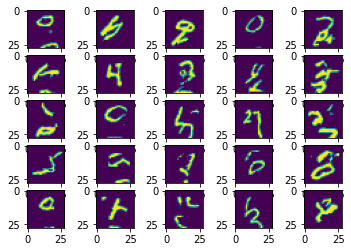

In [0]:
size = 5
fig, axs = plt.subplots(size, size)
for i in range(0, size):
    for j in range(0, size):
        axs[i, j].imshow(s[size * i + j].reshape(28, 28))

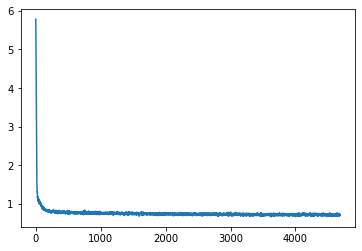

In [0]:
plt.plot(train_loss)
plt.show()

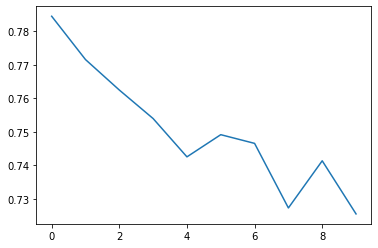

In [0]:
plt.plot(test_loss)
plt.show()